# Modelling and testing for Brighton data

## Imports

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Additional imports
import preprocessingModule as pm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

## Load datasets (train, validation and test)

In [9]:
# load train weather data
weather_data_train = pd.read_csv('cleaned_weather_data.csv')
# load validation weather data
weather_data_validation = pd.read_csv('brighton_validation.csv')
# load test weather data
weather_data_test = pd.read_csv('brighton_test.csv')

All data starting from 2010 to 2020(inclucing) as training set, all 2021 data as validation set and rest of the data (starting from 2023-2024) will be used for processing.

## Apply pre-processing steps to validation and test sets

a function called preprocess and all other relevant functions which were used in data cleaning and preprocessing in assignment 1, were  created and saved in a python script to be used in assignment 2.

Then utilizing this preprocess function all the preprocessing steps were applied to validation and test set.

In [10]:
# apply preprocessing steps to validation set
weather_data_validation = pm.preprocess(weather_data_validation)
weather_data_validation.head()

,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,uvindex
datetime,,,,,,,,,,,,,
2022-01-01 00:00:00,12.0,11.6,97.51,0.015,100.0,0.0,0.0,14.4,193.0,1021.6,99.2,0.0,0.0
2022-01-01 01:00:00,12.2,11.7,96.90,0.000,0.0,0.0,0.0,16.8,209.0,1021.3,100.0,0.0,0.0
2022-01-01 02:00:00,11.8,11.6,98.70,0.000,0.0,0.0,0.0,12.9,211.0,1021.4,100.0,0.0,0.0
2022-01-01 03:00:00,11.8,11.5,98.43,0.000,0.0,0.0,0.0,8.6,143.0,1021.5,97.9,0.0,0.0
2022-01-01 04:00:00,11.8,11.4,97.46,0.000,0.0,0.0,0.0,9.3,164.0,1021.2,99.2,0.0,0.0


In [11]:
# confirm there are no missing values in columns
nan_count_by_year = weather_data_validation.groupby(weather_data_validation.index.year).apply(lambda x: x.isna().sum())
nan_count_by_year

,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,uvindex
datetime,,,,,,,,,,,,,
2022,0,0,0,0,0,0,0,0,0,0,0,0,0


By looking at the above table we can say that there are no missing values in columns after applying preprocessing steps to validation set

In [12]:
# apply preprocessing steps to validation set
weather_data_test = pm.preprocess(weather_data_test)
weather_data_test

,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,uvindex
datetime,,,,,,,,,,,,,
2023-01-01 00:00:00,11.4,10.6,95.05,4.733,100.0,0.0,0.0,33.0,231.0,1005.4,94.1,0.0,0.0
2023-01-01 01:00:00,10.9,10.1,94.89,0.263,100.0,0.0,0.0,29.7,230.0,1006.2,91.6,0.0,0.0
2023-01-01 02:00:00,10.8,8.9,87.93,0.000,0.0,0.0,0.0,29.6,229.0,1006.8,84.8,0.0,0.0
2023-01-01 03:00:00,10.8,9.1,89.42,0.000,0.0,0.0,0.0,26.4,222.0,1007.6,79.2,0.0,0.0
2023-01-01 04:00:00,11.0,9.0,87.46,0.000,0.0,0.0,0.0,29.0,221.0,1008.1,83.3,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-06 07:00:00,5.1,3.5,89.07,0.000,0.0,0.0,0.0,9.6,327.0,1013.2,65.1,0.0,0.0
2024-01-06 08:00:00,5.0,3.5,90.24,0.000,0.0,0.0,0.0,8.9,320.0,1014.0,89.9,0.0,0.0
2024-01-06 09:00:00,4.9,3.9,92.89,0.000,0.0,0.0,0.0,9.6,321.0,1015.0,85.5,23.0,0.0


In [13]:
# confirm there are no missing values in columns
nan_count_by_year = weather_data_test.groupby(weather_data_test.index.year).apply(lambda x: x.isna().sum())
nan_count_by_year

,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,uvindex
datetime,,,,,,,,,,,,,
2023,0,0,0,0,0,0,0,0,0,0,0,0,0
2024,0,0,0,0,0,0,0,0,0,0,0,0,0


By looking at the above table we can say that there are no missing values in columns after applying preprocessing steps to test set

## Calculate solar and wind energy in validation and test sets

After applying preprocessing steps solar energy and wind energy is calculated using solar_energy and wind_energy functions for validation and test sets

In [14]:
# calculate solar and wind energy for validation data
weather_data_validation['solarenergy'] = pm.solar_energy(weather_data_validation['solarradiation'])
weather_data_validation['windenergy'] = pm.wind_energy(weather_data_validation['windspeed'])
weather_data_validation.head()

,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,uvindex,solarenergy,windenergy
datetime,,,,,,,,,,,,,,,
2022-01-01 00:00:00,12.0,11.6,97.51,0.015,100.0,0.0,0.0,14.4,193.0,1021.6,99.2,0.0,0.0,0.0,2.77
2022-01-01 01:00:00,12.2,11.7,96.90,0.000,0.0,0.0,0.0,16.8,209.0,1021.3,100.0,0.0,0.0,0.0,4.40
2022-01-01 02:00:00,11.8,11.6,98.70,0.000,0.0,0.0,0.0,12.9,211.0,1021.4,100.0,0.0,0.0,0.0,1.99
2022-01-01 03:00:00,11.8,11.5,98.43,0.000,0.0,0.0,0.0,8.6,143.0,1021.5,97.9,0.0,0.0,0.0,0.59
2022-01-01 04:00:00,11.8,11.4,97.46,0.000,0.0,0.0,0.0,9.3,164.0,1021.2,99.2,0.0,0.0,0.0,0.75


In [15]:
# calculate solar and wind energy for test data
weather_data_test['solarenergy'] = pm.solar_energy(weather_data_test['solarradiation'])
weather_data_test['windenergy'] = pm.wind_energy(weather_data_test['windspeed'])
weather_data_test.head()

,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,uvindex,solarenergy,windenergy
datetime,,,,,,,,,,,,,,,
2023-01-01 00:00:00,11.4,10.6,95.05,4.733,100.0,0.0,0.0,33.0,231.0,1005.4,94.1,0.0,0.0,0.0,33.35
2023-01-01 01:00:00,10.9,10.1,94.89,0.263,100.0,0.0,0.0,29.7,230.0,1006.2,91.6,0.0,0.0,0.0,24.31
2023-01-01 02:00:00,10.8,8.9,87.93,0.000,0.0,0.0,0.0,29.6,229.0,1006.8,84.8,0.0,0.0,0.0,24.07
2023-01-01 03:00:00,10.8,9.1,89.42,0.000,0.0,0.0,0.0,26.4,222.0,1007.6,79.2,0.0,0.0,0.0,17.07
2023-01-01 04:00:00,11.0,9.0,87.46,0.000,0.0,0.0,0.0,29.0,221.0,1008.1,83.3,0.0,0.0,0.0,22.63


In [16]:
# Convert 'datetime' column to datetime type if it's not already in datetime format in train,set
weather_data_train['datetime'] = pd.to_datetime(weather_data_train['datetime'])
# make the datetime column the index of train set for easier slicing
weather_data_train.set_index('datetime', inplace=True)

# Extract the 'windenergy' column
wind_energy_column = weather_data_train.pop('windenergy')

# Reinsert the 'windenergy' column at the end of the DataFrame
weather_data_train['windenergy'] = wind_energy_column
weather_data_train.head()


,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,uvindex,solarenergy,windenergy
datetime,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1.9,-0.5,84.25,0.417,100.0,0.0,0.0,19.4,11.0,999.9,62.2,0.0,0.0,0.0,6.78
2010-01-01 01:00:00,1.9,-0.5,83.90,0.000,0.0,0.0,0.0,21.8,19.0,999.8,22.4,0.0,0.0,0.0,9.61
2010-01-01 02:00:00,1.4,-0.7,85.76,0.000,0.0,0.0,0.0,17.7,10.0,1000.0,38.0,0.0,0.0,0.0,5.15
2010-01-01 03:00:00,1.4,-0.7,85.69,0.000,0.0,0.0,0.0,18.0,11.0,1000.2,66.7,0.0,0.0,0.0,5.41
2010-01-01 04:00:00,1.3,-0.8,85.72,0.000,0.0,0.0,0.0,17.4,10.0,1000.5,62.8,0.0,0.0,0.0,4.89


train set columns were ordered same as the validation and test set for consistency and easier processing

## Baseline

Before diving into Machine Learning or Neural Network models a baseline model is used to forecast solar and wind energy. To do that all train, validation and test sets were concatenated as a single dataframe to visualize train, valid and test datasets.

In [17]:
# Concatenating the DataFrames row-wise
weather_data_df = pd.concat([weather_data_train, weather_data_validation, weather_data_test])
weather_data_df

,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,uvindex,solarenergy,windenergy
datetime,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1.9,-0.5,84.25,0.417,100.0,0.0,0.0,19.4,11.0,999.9,62.2,0.0,0.0,0.00,6.78
2010-01-01 01:00:00,1.9,-0.5,83.90,0.000,0.0,0.0,0.0,21.8,19.0,999.8,22.4,0.0,0.0,0.00,9.61
2010-01-01 02:00:00,1.4,-0.7,85.76,0.000,0.0,0.0,0.0,17.7,10.0,1000.0,38.0,0.0,0.0,0.00,5.15
2010-01-01 03:00:00,1.4,-0.7,85.69,0.000,0.0,0.0,0.0,18.0,11.0,1000.2,66.7,0.0,0.0,0.00,5.41
2010-01-01 04:00:00,1.3,-0.8,85.72,0.000,0.0,0.0,0.0,17.4,10.0,1000.5,62.8,0.0,0.0,0.00,4.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-06 07:00:00,5.1,3.5,89.07,0.000,0.0,0.0,0.0,9.6,327.0,1013.2,65.1,0.0,0.0,0.00,0.82
2024-01-06 08:00:00,5.0,3.5,90.24,0.000,0.0,0.0,0.0,8.9,320.0,1014.0,89.9,0.0,0.0,0.00,0.65
2024-01-06 09:00:00,4.9,3.9,92.89,0.000,0.0,0.0,0.0,9.6,321.0,1015.0,85.5,23.0,0.0,0.15,0.82


In [18]:
# function to plot train, validation and test datasets
def plot_datasets(data, train_data, valid_data, test_data, energy_type, xlabel, baseline=False):
    fig, ax = plt.subplots(figsize=(16,8))
    ax.plot(data.index, data[energy_type])
    if baseline:
        if energy_type == 'solarenergy':
            ax.plot(valid_data.index, valid_data['solar_baseline_last_period'], '--', color='k', label='Forecast')
        else:
            ax.plot(valid_data.index, valid_data['wind_baseline_last_period'], '--', color='k', label='Forecast')
    ax.axvspan(valid_data.index.min(), valid_data.index.max(), alpha=.2, color='red')  # validation set
    ax.axvspan(test_data.index.min(), test_data.index.max(), alpha=.2, color='blue')  # test set
    ax.set_xlabel('Time (year)')
    ax.set_ylabel(f'{xlabel} (mW)')
    ax.set_xlim(train_data.index.min(), test_data.index.max())
    ax.set_title(f"Plot of {energy_type} over Time")
    plt.tight_layout()
    plt.show()

validation and training sets are highlighted in red and green colors respectively. The baseline is shown black dashed lines

In [19]:
# function to measure the performance of the baseline model
def measure_forecast_error(label, forecast):
    print('MAE = %.2f (mW)' % mean_absolute_error(label, forecast))
    print('R2 = %.2f' % r2_score(label, forecast))

<br>For baseline, 2021 data was copied to 2022 validation dataset. This is done for both solar and wind energy validation datasets. Baseline is the forecasted values for 2022.

### Baseline for hourly data

As we will be forecasting hourly solar and wind energy baseline is created using hourly data and plotted the datasets with the baseline.

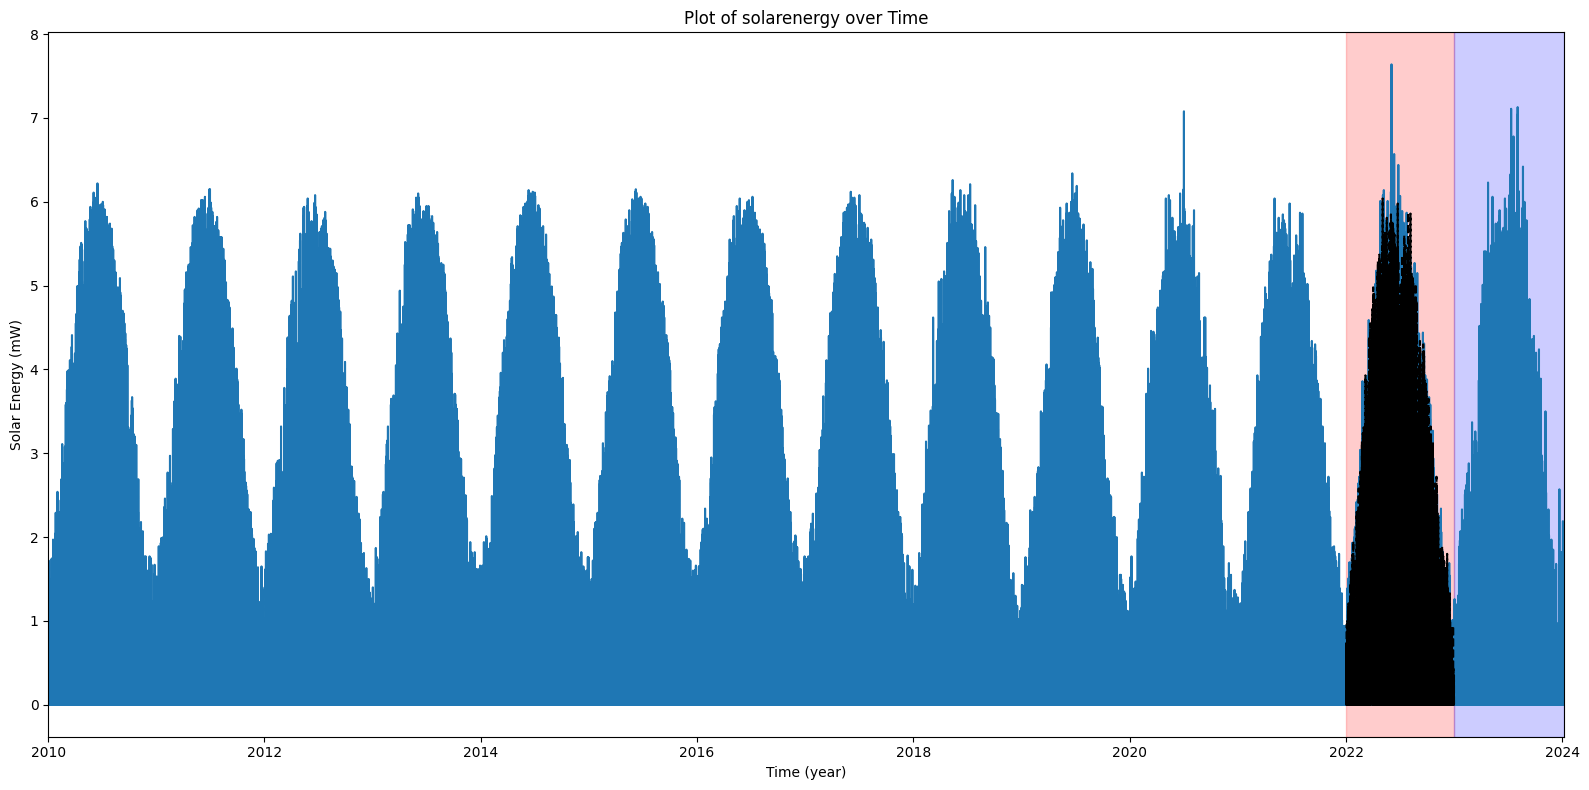

forecast error for solarenergy
MAE = 0.39 (mW)
R2 = 0.62


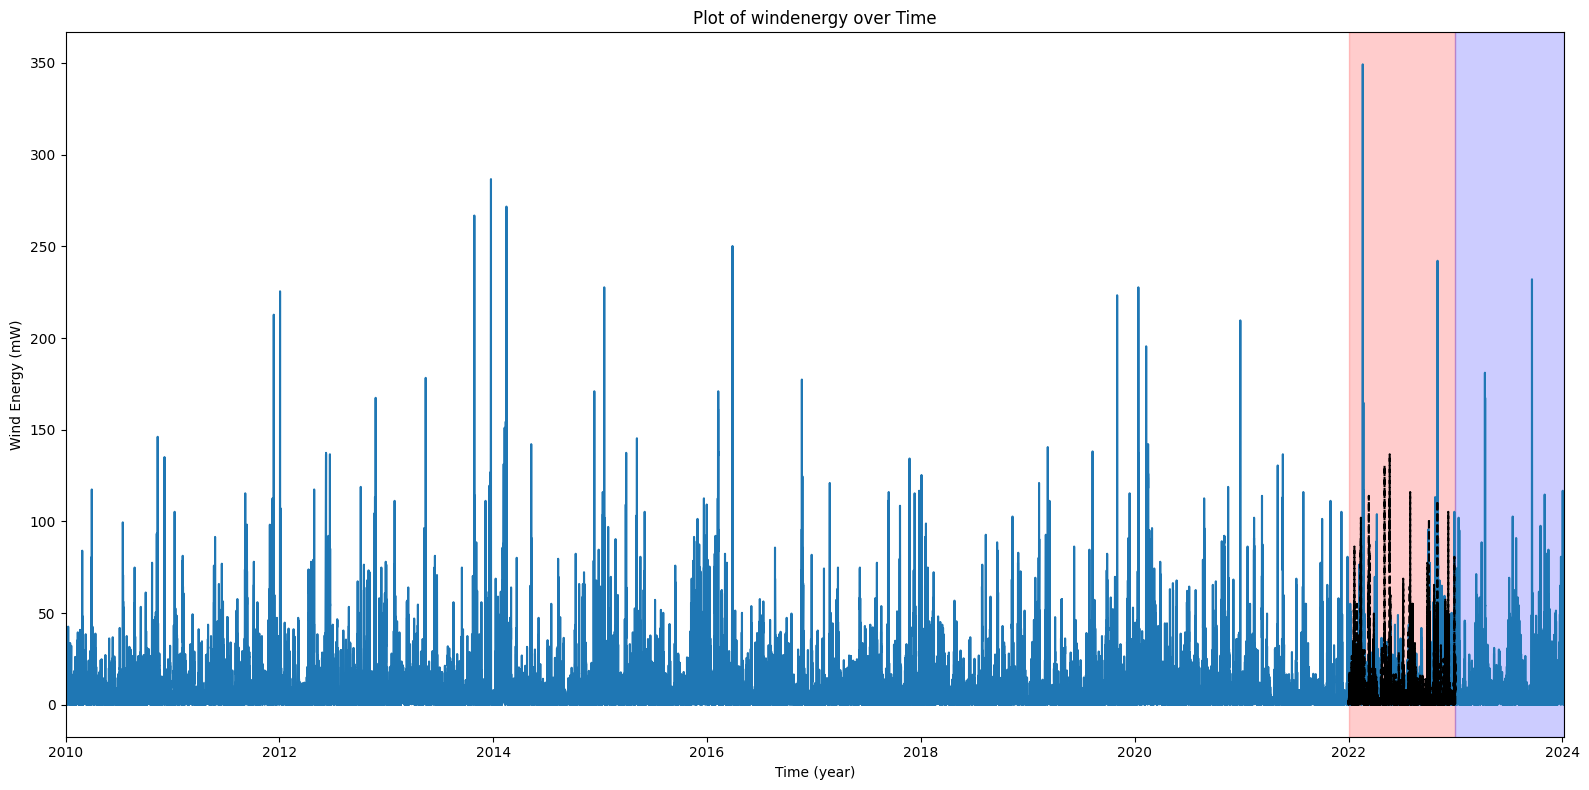

forecast error for windenergy
MAE = 9.20 (mW)
R2 = -0.74


In [20]:
weather_data_validation['solar_baseline_last_period'] = weather_data_train.loc['2021']['solarenergy'].values
weather_data_validation['wind_baseline_last_period'] = weather_data_train.loc['2021']['windenergy'].values

plot_datasets(weather_data_df, weather_data_train, weather_data_validation, weather_data_test, 'solarenergy', 'Solar Energy', True)
print('forecast error for solarenergy')
measure_forecast_error(weather_data_validation['solarenergy'], weather_data_validation['solar_baseline_last_period'])
plot_datasets(weather_data_df, weather_data_train, weather_data_validation, weather_data_test, 'windenergy', 'Wind Energy', True)
print('forecast error for windenergy')
measure_forecast_error(weather_data_validation['windenergy'], weather_data_validation['wind_baseline_last_period'])

we can see that since solar energy has clear periodicity it has positive R2 value compared to wind energy. Solar energy baseline achieves 0.39mW meaning predicted value will be 0.39 lower than the actual value. in Wind energy baseline, it achieves 9.20mW with -0.74 R2 score. We can see solar energy baseline is better than wind energy baseline.

### Baseline for monthly data

Monthly baseline was also created for better visualization.

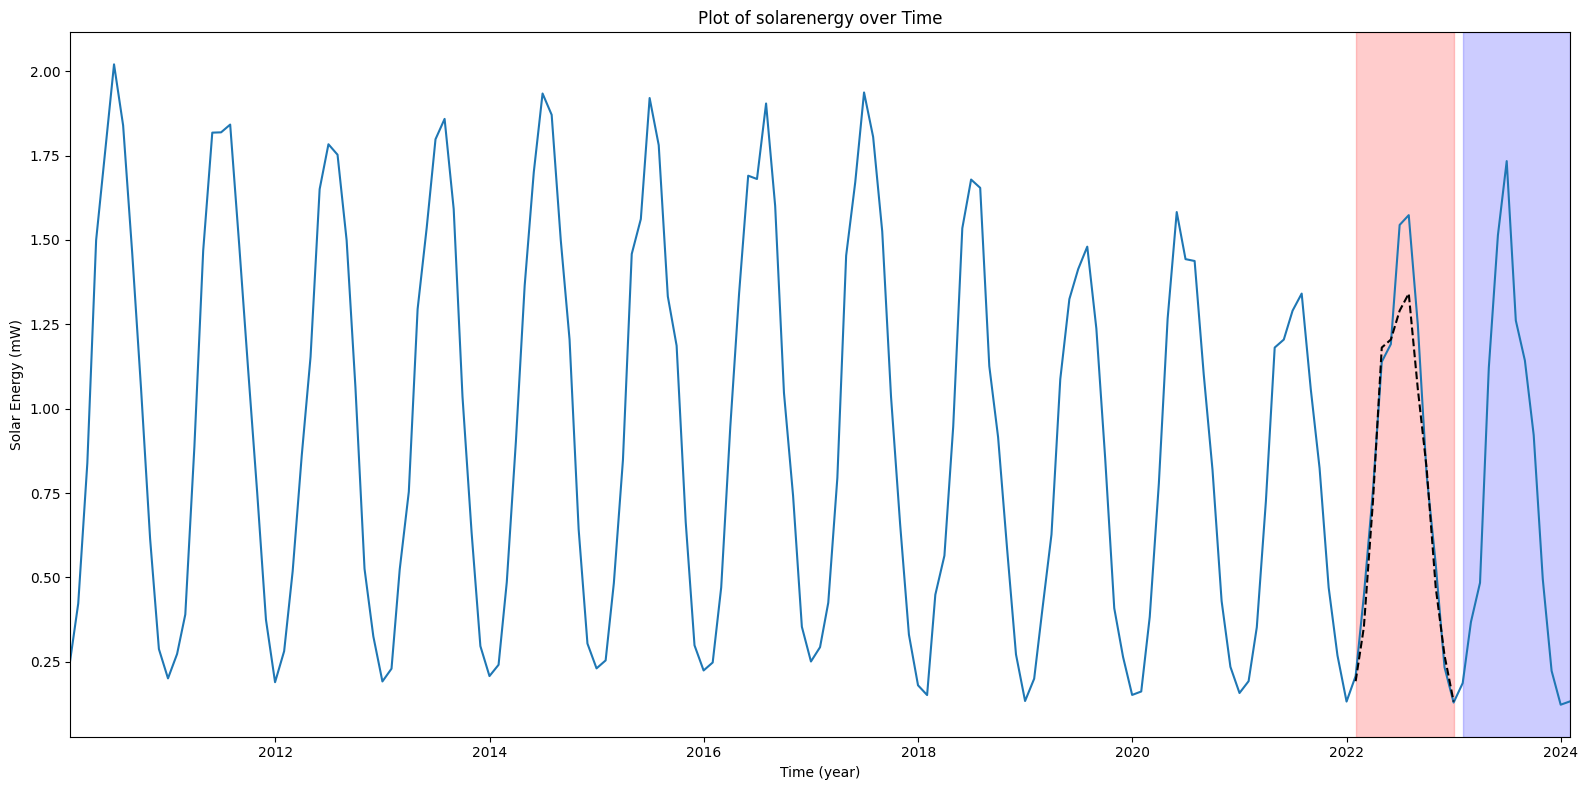

forecast error for solarenergy
MAE = 0.08 (mW)
R2 = 0.94


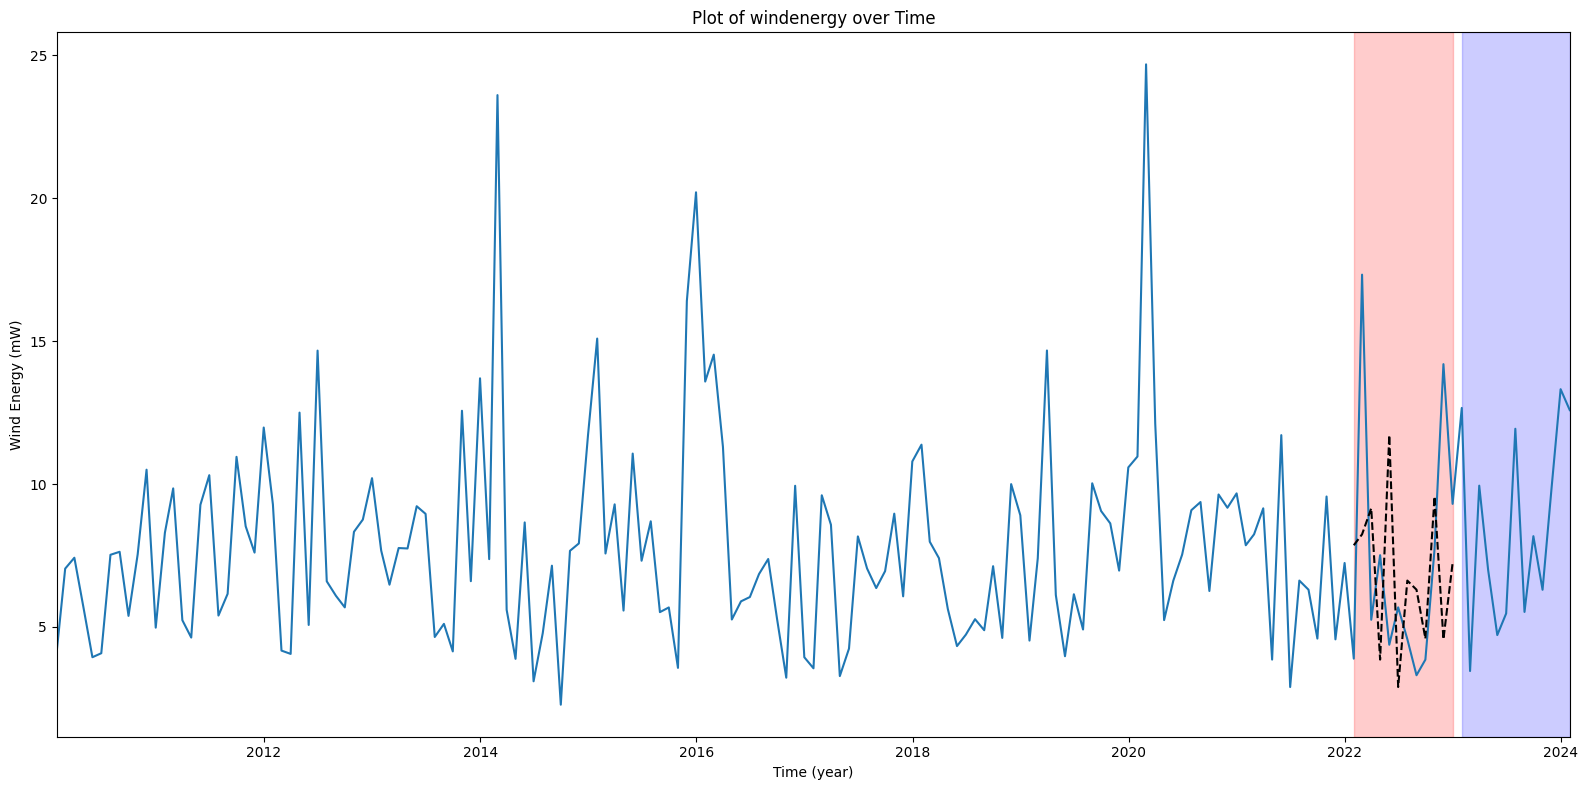

forecast error for windenergy
MAE = 4.17 (mW)
R2 = -0.41


In [21]:
# downsample to monthly recordings
df_monthly = weather_data_df.resample('M').mean().ffill()  # one value per day
df_monthly

df_monthly_validation = df_monthly.loc['2022']
df_monthly_validation['solar_baseline_last_period'] = df_monthly.loc['2021']['solarenergy'].values
df_monthly_validation['wind_baseline_last_period'] = df_monthly.loc['2021']['windenergy'].values


plot_datasets(df_monthly, df_monthly[:'2021'], df_monthly_validation, df_monthly['2023':], 'solarenergy', 'Solar Energy', True)
print('forecast error for solarenergy')
measure_forecast_error(df_monthly_validation['solarenergy'], df_monthly_validation['solar_baseline_last_period'])
plot_datasets(df_monthly, df_monthly[:'2021'], df_monthly_validation, df_monthly['2023':], 'windenergy', 'Wind Energy', True)
print('forecast error for windenergy')
measure_forecast_error(df_monthly_validation['windenergy'], df_monthly_validation['wind_baseline_last_period'])

Monthly data baseline achieves MAE of 0.08 and 4.17 mW and R2 scores of 0.94 and -0.41 for solar and wind energy respetively. From this also we can see that solar energy baseline is better than wind energy baseline.

## Model Training

## Feature selection

From the mutual information histograms shown in assignment 1 we can see that precip, precipprob, snow and snowdepth don't have much importance for wind and solar energy predictions. therefore these columns were dropped and other 9 columns were selected as features for both solar and wind energy forecasting.

### Separate features and targets for solar and wind energy models

In [23]:
# columns to drop
drop_columns = ['solarenergy', 'windenergy', 'precip', 'precipprob', 'snow', 'snowdepth']
additional_valid_cols = ['solar_baseline_last_period', 'wind_baseline_last_period']

# seperate features and target solar energy for train set
Y_train_solar = weather_data_train[['solarenergy']]
X_train = weather_data_train.drop(columns=drop_columns)

# seperate features and target solar energy for validation set
Y_valid_solar = weather_data_validation[['solarenergy']]
X_valid = weather_data_validation.drop(columns=(drop_columns + additional_valid_cols))

# seperate features and target solar energy for test set
Y_test_solar = weather_data_test[['solarenergy']]
X_test= weather_data_test.drop(columns=drop_columns)
print(Y_train_solar.head())
print(X_train.head())

                     solarenergy
datetime                        
2010-01-01 00:00:00          0.0
2010-01-01 01:00:00          0.0
2010-01-01 02:00:00          0.0
2010-01-01 03:00:00          0.0
2010-01-01 04:00:00          0.0
                     temp  dew  humidity  windspeed  winddir  \
datetime                                                       
2010-01-01 00:00:00   1.9 -0.5     84.25       19.4     11.0   
2010-01-01 01:00:00   1.9 -0.5     83.90       21.8     19.0   
2010-01-01 02:00:00   1.4 -0.7     85.76       17.7     10.0   
2010-01-01 03:00:00   1.4 -0.7     85.69       18.0     11.0   
2010-01-01 04:00:00   1.3 -0.8     85.72       17.4     10.0   

                     sealevelpressure  cloudcover  solarradiation  uvindex  
datetime                                                                    
2010-01-01 00:00:00             999.9        62.2             0.0      0.0  
2010-01-01 01:00:00             999.8        22.4             0.0      0.0  
2010-01-01 0

In [24]:
# seperate target wind energy for train, validation and test sets. Since features are same as solar energy it will not be processed again.
Y_train_wind = weather_data_train[['windenergy']]
Y_valid_wind  = weather_data_validation[['windenergy']]
Y_test_wind  = weather_data_test[['windenergy']]
print(Y_train_wind.head())

                     windenergy
datetime                       
2010-01-01 00:00:00        6.78
2010-01-01 01:00:00        9.61
2010-01-01 02:00:00        5.15
2010-01-01 03:00:00        5.41
2010-01-01 04:00:00        4.89


### Scale features and targets for solar and wind energy models

To scale the features and target values MinMaxScaler was used.

In [25]:
# scale features
X_scaler = MinMaxScaler()
X_scaler.fit(X_train)  # find parameters using training set only

scaled_X_train = X_scaler.transform(X_train)  # transform the training feature data set
scaled_X_valid= X_scaler.transform(X_valid)  # transform the validation data set
scaled_X_test = X_scaler.transform(X_test)  # transform the test data set

In [26]:
# scalling target values for solar energy forecasting
Y_scaler_solar = MinMaxScaler()
Y_scaler_solar.fit(Y_train_solar)  # find parameters using training set only

scaled_Y_train_solar = Y_scaler_solar.transform(Y_train_solar)  # transform the training feature data set
scaled_Y_valid_solar = Y_scaler_solar.transform(Y_valid_solar)  # transform the validation data set
scaled_Y_test_solar = Y_scaler_solar.transform(Y_test_solar)  # transform the test data set

# scalling target values for wind energy forecasting
Y_scaler_wind = MinMaxScaler()
Y_scaler_wind.fit(Y_train_wind)  # find parameters using training set only

scaled_Y_train_wind = Y_scaler_wind.transform(Y_train_wind)  # transform the training feature data set
scaled_Y_valid_wind = Y_scaler_wind.transform(Y_valid_wind)  # transform the validation data set
scaled_Y_test_wind = Y_scaler_wind.transform(Y_test_wind)  # transform the test data set

In [27]:
# Convert the scaled data back to a DataFrame
scaled_df_train = pd.DataFrame(scaled_X_train, columns=X_train.columns, index=X_train.index)
scaled_df_valid = pd.DataFrame(scaled_X_valid, columns=X_valid.columns, index=X_valid.index)
scaled_df_test = pd.DataFrame(scaled_X_test, columns=X_test.columns, index=X_test.index)

In [28]:
print(scaled_df_train.head())

                         temp       dew  humidity  windspeed   winddir  \
datetime                                                                 
2010-01-01 00:00:00  0.262530  0.349057  0.791832   0.286982  0.028667   
2010-01-01 01:00:00  0.262530  0.349057  0.787206   0.322485  0.050932   
2010-01-01 02:00:00  0.250597  0.342767  0.811790   0.261834  0.025884   
2010-01-01 03:00:00  0.250597  0.342767  0.810864   0.266272  0.028667   
2010-01-01 04:00:00  0.248210  0.339623  0.811261   0.257396  0.025884   

                     sealevelpressure  cloudcover  solarradiation  uvindex  
datetime                                                                    
2010-01-01 00:00:00          0.404101       0.622             0.0      0.0  
2010-01-01 01:00:00          0.402895       0.224             0.0      0.0  
2010-01-01 02:00:00          0.405308       0.380             0.0      0.0  
2010-01-01 03:00:00          0.407720       0.667             0.0      0.0  
2010-01-01 04:00:00

In [29]:
print(scaled_df_train.shape)
print(scaled_df_valid.shape)
print(scaled_df_test.shape)

(105192, 9)
(8760, 9)
(8892, 9)


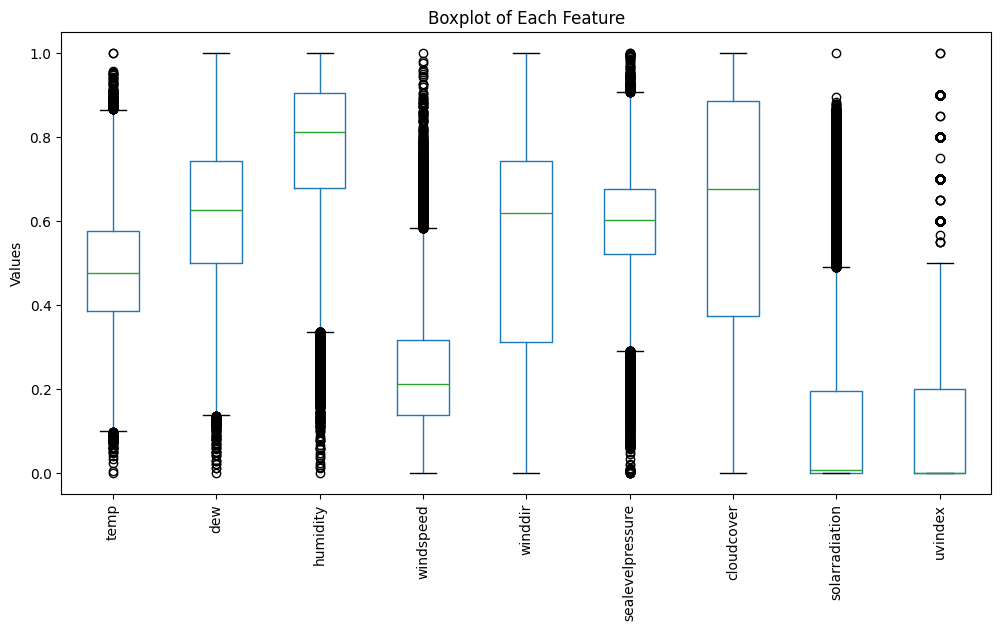

In [30]:
scaled_df_train.boxplot(figsize=(12, 6), grid=False)
plt.title('Boxplot of Each Feature')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.show()

Boxplot of features after scalling is shown above. MinMaxScaler converts data to values berween 0 and 1 for each feature. We can see that all the selected features have better distribution.

## Train Model

When selecting a model to forecast solar and wind energy, a research was done to find the best model for timeseries data and for the given problem.
<br><br> A literature review done by Jaume et al. on Wind Energy Forecasting with Neural Networks (https://www.scielo.org.mx/pdf/cys/v22n4/1405-5546-cys-22-04-1085.pdf) metioned that RNN with LSTM Architecture gives the best results.
<br> Therefore, RNN model with LSTM layers was used to forecast solar and wind energy 24h in advance.

In [26]:
# Function to plot history with neural networks
def plot_history(hist):
  n_ = len(hist.history['mae'])
  plt.plot(range(1, n_+1), np.asarray(hist.history['mae']), 'bo', label='MAE on training set') # Mean Absolute Error on training set
  plt.plot(range(1, n_+1), np.asarray(hist.history['val_mae']), 'b', label='MAE on validation set') # Mean Absolute Error on validation set
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("MAE (mW)")
  plt.ylim([0, None])
  plt.axhline(y=50)
  plt.show()

In [33]:
# function to reshape features and target variables to pass on to Neural Network model as inputs. 24 inputs and 1 output
def reshape_dataset(X, Y, time_steps=24):
    X_seq, Y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:(i + time_steps)]) # append 24 past data
        Y_seq.append(Y[i + time_steps]) # append the 24th target value
    return np.array(X_seq), np.array(Y_seq)

In [27]:
# common function to train solar and wind energy models.
def train_model(scaled_X_train, scaled_Y_train, scaled_X_valid, scaled_Y_valid):
    # Create sequences
    time_steps = 24  # Number of timesteps to use for prediction
    no_of_features = 9 # no of features
    
    # Create sequences for training - train and validation sets
    X_train_seq, y_train_seq = reshape_dataset(scaled_X_train, scaled_Y_train, time_steps)
    X_val_seq, y_val_seq = reshape_dataset(scaled_X_valid, scaled_Y_valid, time_steps)

    # Define the model RNN model with LSTM layers
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(time_steps, no_of_features)),
        LSTM(50),
        Dropout(0.25),
        Dense(units=1)
    ])

    # display model summary
    model.summary()
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])
    plot_history(history)

    # evaluate model on validation set
    loss, additional_metrics = model.evaluate(X_val_seq, y_val_seq)
    print("Val_loss:", loss)
    print("Additional Metrics:", additional_metrics)
    return model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,995 (164.04 KB)

 Trainable params: 41,995 (164.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 0.0086 - mae: 0.0574 - val_loss: 0.0038 - val_mae: 0.0309
Epoch 2/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 0.0023 - mae: 0.0285 - val_loss: 0.0035 - val_mae: 0.0312
Epoch 3/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0021 - mae: 0.0270 - val_loss: 0.0036 - val_mae: 0.0297
Epoch 4/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 0.0020 - mae: 0.0258 - val_loss: 0.0034 - val_mae: 0.0280
Epoch 5/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 0.0019 - mae: 0.0247 - val_loss: 0.0033 - val_mae: 0.0275
Epoch 6/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 0.0019 - mae: 0.0248 - val_loss: 0.0037 - val_mae: 0.0304
Epoch 7/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - loss: 0.0018 - mae: 0.0243 - val_loss: 0.0033 - val_mae: 0.0313
Epoch 8/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 0.0018 - mae: 0.0243 - val_loss: 0.0034 - val_mae: 0.0277
Epoch 9/50
3287/3287 ━━━━━━━━━━━

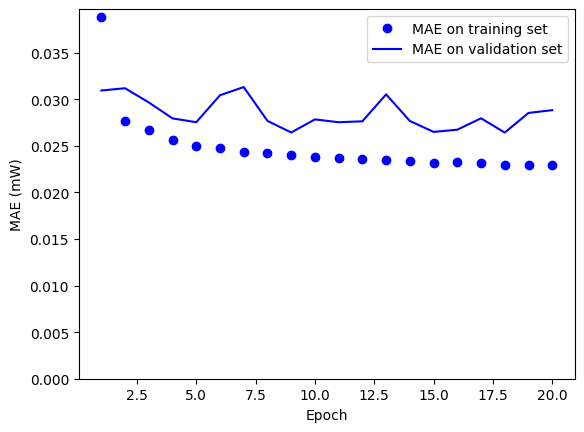

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0028 - mae: 0.0247
Val_loss: 0.003115688916295767
Additional Metrics: 0.026500685140490532


In [28]:
# call train_model function to train model for forecasting solar energy
model_solar = train_model(scaled_X_train, scaled_Y_train_solar, scaled_X_valid, scaled_Y_valid_solar)
model_solar.save('model/solar.keras') # save model

The RNN model was defined with two LSTM layers with 64 and 50 units resoectively and the dropout layer followed by the dense layer.
<br> when the model trained for solar energy and evaluated woth validation set it gives an average validation loss of 0.003mW

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,995 (164.04 KB)

 Trainable params: 41,995 (164.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 0.0014 - mae: 0.0218 - val_loss: 6.0628e-04 - val_mae: 0.0140
Epoch 2/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - loss: 4.9857e-04 - mae: 0.0125 - val_loss: 5.4209e-04 - val_mae: 0.0120
Epoch 3/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 4.5972e-04 - mae: 0.0114 - val_loss: 4.6127e-04 - val_mae: 0.0109
Epoch 4/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 4.2827e-04 - mae: 0.0109 - val_loss: 4.5332e-04 - val_mae: 0.0102
Epoch 5/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 4.1503e-04 - mae: 0.0106 - val_loss: 4.5518e-04 - val_mae: 0.0093
Epoch 6/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 4.1561e-04 - mae: 0.0105 - val_loss: 5.0203e-04 - val_mae: 0.0103
Epoch 7/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 4.3375e-04 - mae: 0.0107 - val_loss: 4.4507e-04 - val_mae: 0.0102
Epoch 8/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 4.0188e-04 - mae: 0.0102 - val_loss: 4

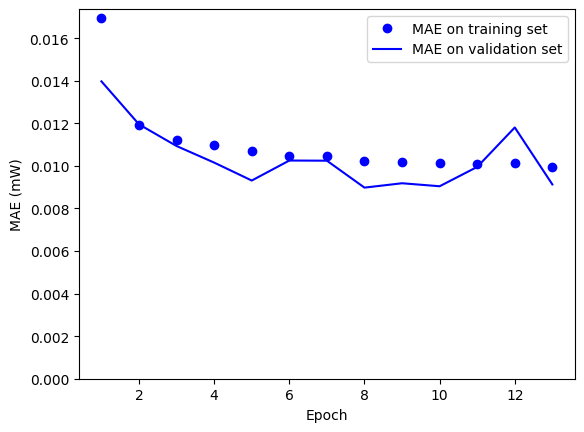

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4414e-04 - mae: 0.0089
Val_loss: 0.00042397109791636467
Additional Metrics: 0.008979089558124542


In [30]:
# call train_model function to train model for forecasting wind energy
model_wind = train_model(scaled_X_train, scaled_Y_train_wind, scaled_X_valid, scaled_Y_valid_wind)
model_wind.save('model/wind.keras') # save model

The RNN model was defined with two LSTM layers with 64 and 50 units resoectively and the dropout layer followed by the dense layer.
<br> when the model trained for wind energy and evaluated woth validation set it gives an average validation loss of 0.0004mW

In [61]:
# function to calculate model performance
def calculate_performance(y_actual, y_pred):
    # Calculate MSE
    mse = mean_squared_error(y_actual, y_pred)
    print("Mean Squared Error:", round(mse, 2))
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:", round(rmse, 2))
    
    # Calculate MAE
    mae = mean_absolute_error(y_actual, y_pred)
    print("Mean Absolute Error:", round(mae,2))
    
    # Calculate R-squared
    r2 = r2_score(y_actual, y_pred)
    print("R-squared:", round(r2,2))

In [35]:
# consider from 24th row since first solar and wind energy is forecasted from 24th row starting from the begining.
new_weather_data_validation= weather_data_validation.iloc[24:]

## Make Predictions

### Make predictions for solar and wind energy on validation set and evaluate

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


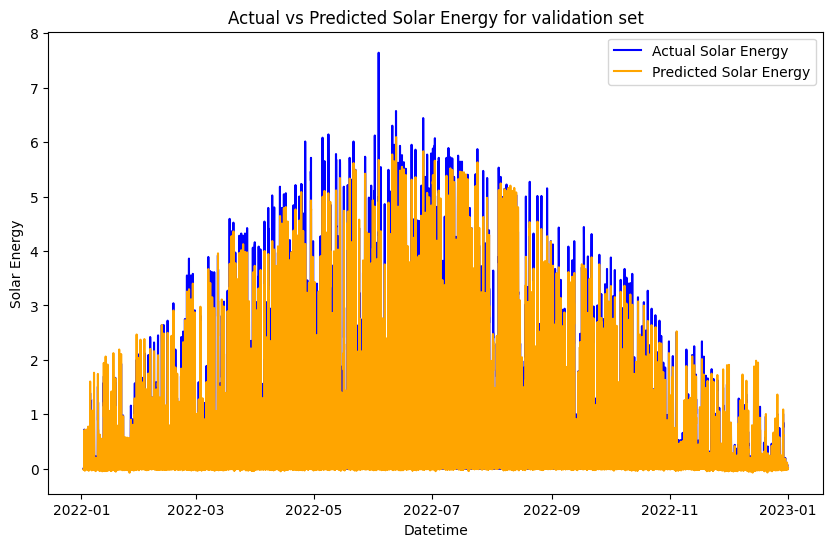

Mean Squared Error: 0.16
Root Mean Squared Error: 0.4
Mean Absolute Error: 0.19
R-squared: 0.92


In [62]:
# Make predictions
X_val_seq_solar, y_val_seq_solar = reshape_dataset(scaled_X_valid, scaled_Y_valid_solar, 24)

# load solar model
model_solar = load_model("model/solar.keras")
predictions_solar = model_solar.predict(X_val_seq_solar)
# Inverse scale the predictions if needed
predictions_solar = Y_scaler_solar.inverse_transform(predictions_solar)
Y_actual_solar = Y_scaler_solar.inverse_transform(y_val_seq_solar)

# Plot actual vs predicted values for solar energy
plt.figure(figsize=(10, 6))
plt.plot(new_weather_data_validation.index, Y_actual_solar, label='Actual Solar Energy', color='blue')
plt.plot(new_weather_data_validation.index, predictions_solar, label='Predicted Solar Energy', color='orange')
plt.xlabel('Datetime')
plt.ylabel('Solar Energy')
plt.title('Actual vs Predicted Solar Energy for validation set')
plt.legend()
plt.savefig('actual_predicted_solar_val.png')
plt.show()

calculate_performance(Y_actual_solar, predictions_solar)

By looking at the solar model's performance on validation set, we can say that it has a MAE of 0.16 meaning our predicted solar energy will be 0.16 mW less than the actual value. This model shows a higher and better R2 score which is 0.92 > 0.62(baseline). Therefore we can say that this model performs better than our baseline model for solar energy prediction.

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


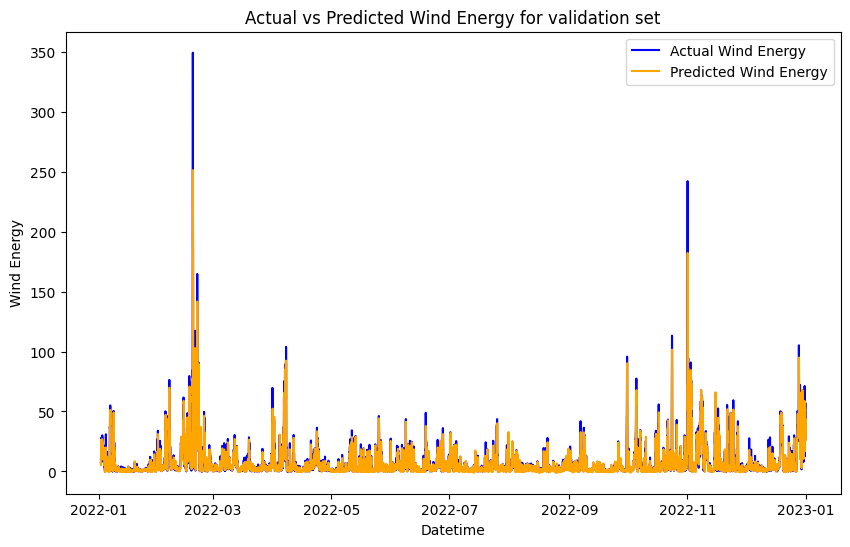

Mean Squared Error: 34.84
Root Mean Squared Error: 5.9
Mean Absolute Error: 2.57
R-squared: 0.81


In [63]:
# Make predictions
X_val_seq_wind, y_val_seq_wind = reshape_dataset(scaled_X_valid, scaled_Y_valid_wind, 24)

# load wind model
model_wind = load_model("model/wind.keras")
predictions_wind = model_wind.predict(X_val_seq_wind)
# Inverse scale the predictions
predictions_wind = Y_scaler_wind.inverse_transform(predictions_wind)
Y_actual_wind = Y_scaler_wind.inverse_transform(y_val_seq_wind)

# Plot actual vs predicted values for solar energy
plt.figure(figsize=(10, 6))
plt.plot(new_weather_data_validation.index, Y_actual_wind, label='Actual Wind Energy', color='blue')
plt.plot(new_weather_data_validation.index, predictions_wind, label='Predicted Wind Energy', color='orange')
plt.xlabel('Datetime')
plt.ylabel('Wind Energy')
plt.title('Actual vs Predicted Wind Energy for validation set')
plt.legend()
plt.savefig('actual_predicted_solar_val.png')
plt.show()
calculate_performance(Y_actual_wind, predictions_wind)

By looking at the wind model's performance on validation set, we can say that it has a MAE of 2.57 meaning our predicted wind energy will be 2.57 mW less or higher than the actual value. This model shows a higher and better R2 score which is 0.81 > -0.74(baseline) way higher than the baseline model. Therefore we can say that this model performs better than our baseline model for wind energy prediction.

### Make predictions for solar and wind energy on test set

In [41]:
new_weather_data_test = weather_data_test.iloc[24:]

278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


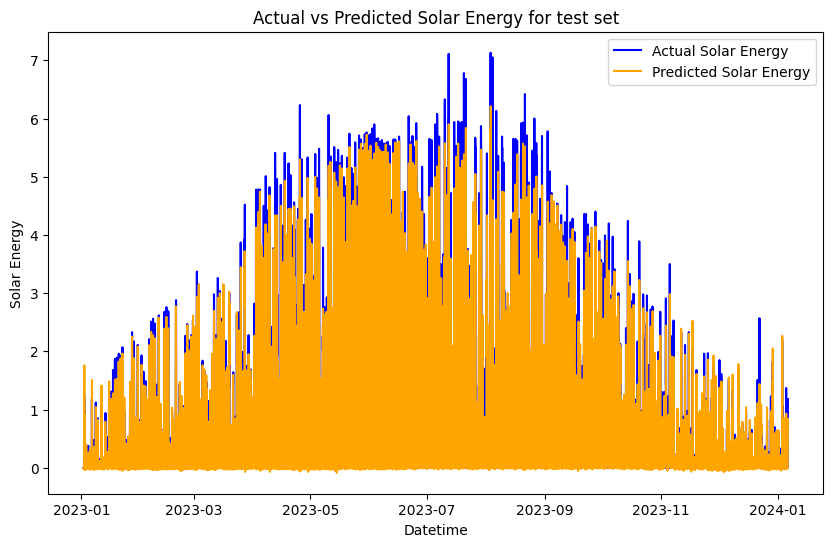

Mean Squared Error: 0.23
Root Mean Squared Error: 0.48
Mean Absolute Error: 0.21
R-squared: 0.88


In [64]:
X_test_seq_solar, y_test_seq_solar = reshape_dataset(scaled_X_test, scaled_Y_test_solar, 24)
test_predictions_solar = model_solar.predict(X_test_seq_solar)
# Inverse scale the predictions if needed
test_predictions_solar = Y_scaler_solar.inverse_transform(test_predictions_solar)
test_Y_actual_solar = Y_scaler_solar.inverse_transform(y_test_seq_solar)

# Plot actual vs predicted values for solar energy
plt.figure(figsize=(10, 6))
plt.plot(new_weather_data_test.index, test_Y_actual_solar, label='Actual Solar Energy', color='blue')
plt.plot(new_weather_data_test.index, test_predictions_solar, label='Predicted Solar Energy', color='orange')  # Use predictions[:, 0] for solar energy
plt.xlabel('Datetime')
plt.ylabel('Solar Energy')
plt.title('Actual vs Predicted Solar Energy for test set')
plt.legend()
plt.show()

# calculate performance on test set
calculate_performance(test_Y_actual_solar, test_predictions_solar)


Eventhough MAE is little bit higher and R2 score is little bit lower than the validation set from the values we can say model performs better on test set as same as validation set for wind energy.

278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


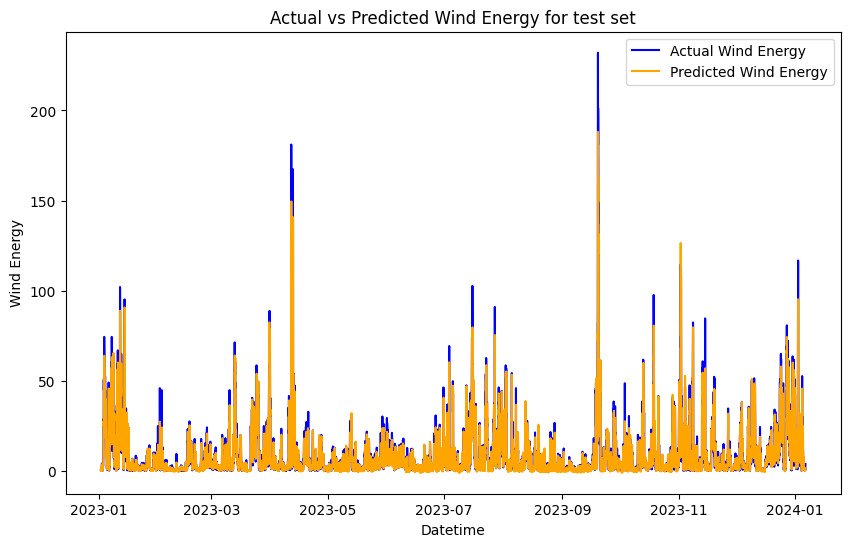

Mean Squared Error: 39.29
Root Mean Squared Error: 6.27
Mean Absolute Error: 2.86
R-squared: 0.81


In [65]:
X_test_seq_wind, y_test_seq_wind = reshape_dataset(scaled_X_test, scaled_Y_test_wind, 24)
test_predictions_wind = model_wind.predict(X_test_seq_wind)
# Inverse scale the predictions
test_predictions_wind = Y_scaler_wind.inverse_transform(test_predictions_wind)
test_Y_actual_wind = Y_scaler_wind.inverse_transform(y_test_seq_wind)

# Plot actual vs predicted values for solar energy
plt.figure(figsize=(10, 6))
plt.plot(new_weather_data_test.index, test_Y_actual_wind, label='Actual Wind Energy', color='blue')
plt.plot(new_weather_data_test.index, test_predictions_wind, label='Predicted Wind Energy', color='orange')  # Use predictions[:, 0] for solar energy
plt.xlabel('Datetime')
plt.ylabel('Wind Energy')
plt.title('Actual vs Predicted Wind Energy for test set')
plt.legend()
plt.show()

# calculate performance on test set
calculate_performance(test_Y_actual_wind, test_predictions_wind)

MAE is bit higher and R2 score is little bit higher than the validation set from the values we can say model performs better on test set as same as validation set for wind energy.

## Analyze predicted solar and wind energy for surplus forecasting

In [44]:
# add new columns with predicted solar and wind energies.
new_weather_data_test['solarenergyPredicted'] = test_predictions_solar
new_weather_data_test['windenergyPredicted'] = test_predictions_wind

new_weather_data_test.head()

,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,uvindex,solarenergy,windenergy,solarenergyPredicted,windenergyPredicted
datetime,,,,,,,,,,,,,,,,,
2023-01-02 00:00:00,7.1,6.6,96.73,0.041,100.0,0.0,0.0,6.9,275.0,1009.5,91.6,0.0,0.0,0.0,0.30,-0.007919,0.073835
2023-01-02 01:00:00,6.7,6.3,96.99,0.018,100.0,0.0,0.0,6.0,232.0,1010.2,91.6,0.0,0.0,0.0,0.20,-0.011871,0.308973
2023-01-02 02:00:00,6.6,6.3,97.73,0.031,100.0,0.0,0.0,8.0,245.0,1010.7,76.6,0.0,0.0,0.0,0.48,-0.016089,0.093643
2023-01-02 03:00:00,6.4,5.9,96.69,0.000,0.0,0.0,0.0,6.2,282.0,1011.4,77.8,0.0,0.0,0.0,0.22,-0.012691,0.593489
2023-01-02 04:00:00,8.1,7.7,97.56,0.000,0.0,0.0,0.0,13.1,226.0,1011.5,91.6,0.0,0.0,0.0,2.09,-0.008499,0.213686


In [45]:
# calculate total energy both actual and predicted.
new_weather_data_test['totaEnergyActual'] = new_weather_data_test['windenergy'] + new_weather_data_test['solarenergy']
new_weather_data_test['totaEnergyPredicted'] = new_weather_data_test['windenergyPredicted'] + new_weather_data_test['solarenergyPredicted']
new_weather_data_test.head()

,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,uvindex,solarenergy,windenergy,solarenergyPredicted,windenergyPredicted,totaEnergyActual,totaEnergyPredicted
datetime,,,,,,,,,,,,,,,,,,,
2023-01-02 00:00:00,7.1,6.6,96.73,0.041,100.0,0.0,0.0,6.9,275.0,1009.5,91.6,0.0,0.0,0.0,0.30,-0.007919,0.073835,0.30,0.065916
2023-01-02 01:00:00,6.7,6.3,96.99,0.018,100.0,0.0,0.0,6.0,232.0,1010.2,91.6,0.0,0.0,0.0,0.20,-0.011871,0.308973,0.20,0.297102
2023-01-02 02:00:00,6.6,6.3,97.73,0.031,100.0,0.0,0.0,8.0,245.0,1010.7,76.6,0.0,0.0,0.0,0.48,-0.016089,0.093643,0.48,0.077554
2023-01-02 03:00:00,6.4,5.9,96.69,0.000,0.0,0.0,0.0,6.2,282.0,1011.4,77.8,0.0,0.0,0.0,0.22,-0.012691,0.593489,0.22,0.580797
2023-01-02 04:00:00,8.1,7.7,97.56,0.000,0.0,0.0,0.0,13.1,226.0,1011.5,91.6,0.0,0.0,0.0,2.09,-0.008499,0.213686,2.09,0.205187


In [46]:
# Apply determine_surplus function to create the 'surplus' column : actual and predicted surplus is determined
new_weather_data_test['surplusActual'] = new_weather_data_test['totaEnergyActual'].apply(pm.determine_surplus)
new_weather_data_test['surplusPredicted'] = new_weather_data_test['totaEnergyPredicted'].apply(pm.determine_surplus)
new_weather_data_test.head()

,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,...,solarradiation,uvindex,solarenergy,windenergy,solarenergyPredicted,windenergyPredicted,totaEnergyActual,totaEnergyPredicted,surplusActual,surplusPredicted
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-02 00:00:00,7.1,6.6,96.73,0.041,100.0,0.0,0.0,6.9,275.0,1009.5,...,0.0,0.0,0.0,0.30,-0.007919,0.073835,0.30,0.065916,0,0
2023-01-02 01:00:00,6.7,6.3,96.99,0.018,100.0,0.0,0.0,6.0,232.0,1010.2,...,0.0,0.0,0.0,0.20,-0.011871,0.308973,0.20,0.297102,0,0
2023-01-02 02:00:00,6.6,6.3,97.73,0.031,100.0,0.0,0.0,8.0,245.0,1010.7,...,0.0,0.0,0.0,0.48,-0.016089,0.093643,0.48,0.077554,0,0
2023-01-02 03:00:00,6.4,5.9,96.69,0.000,0.0,0.0,0.0,6.2,282.0,1011.4,...,0.0,0.0,0.0,0.22,-0.012691,0.593489,0.22,0.580797,0,0
2023-01-02 04:00:00,8.1,7.7,97.56,0.000,0.0,0.0,0.0,13.1,226.0,1011.5,...,0.0,0.0,0.0,2.09,-0.008499,0.213686,2.09,0.205187,0,0


1 - surplus and 0 - no surplus

In [47]:
# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(new_weather_data_test['surplusActual'], new_weather_data_test['surplusPredicted']).ravel()

# Output the number of false positives
print("False Positives:", fp)
print('totla:',(tn+fp+fn+tp))

False Positives: 5
totla: 8868


From the total of 8868 values in the test set, 5 false positives which means actually the is no surplus but predicted as surplus. Below shows the proper confusion matrix with all results

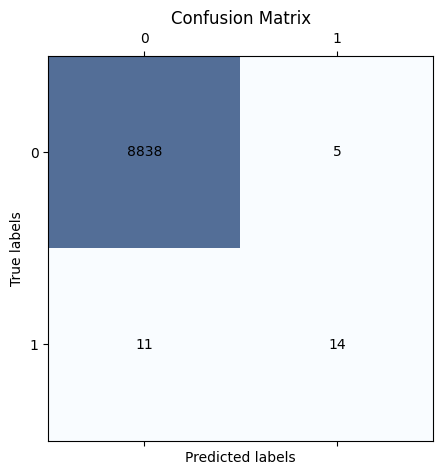

In [48]:
# Compute confusion matrix and display
cm = confusion_matrix(new_weather_data_test['surplusActual'], new_weather_data_test['surplusPredicted'])

# Define the plot
fig, ax = plt.subplots(figsize=(5,5))

# Using matplotlib to plot the confusion matrix
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.7)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.set_xticklabels([''] + list(set(new_weather_data_test['surplusPredicted'])))
ax.set_yticklabels([''] + list(set(new_weather_data_test['surplusActual'])))
plt.savefig('confusion_matrix.png')

plt.show()

Out of 8868 data points, 8852 were predicted correctly by the model with 8838 as no surplus and 14 as surplus. But, 11 were predicted as false negatives (actual surplus, predicted as no surplus) and 5 as false positives (actual no surplus, predicted as surplus)

In [49]:
# get the totaEnergyActual, totaEnergyPredicted, surplusActual and surplusPredicted columns seperately for further analysis
actual_pred_surplus_df = new_weather_data_test[['totaEnergyActual', 'totaEnergyPredicted', 'surplusActual', 'surplusPredicted']]
actual_pred_surplus_df

,totaEnergyActual,totaEnergyPredicted,surplusActual,surplusPredicted
datetime,,,,
2023-01-02 00:00:00,0.30,0.065916,0,0
2023-01-02 01:00:00,0.20,0.297102,0,0
2023-01-02 02:00:00,0.48,0.077554,0,0
2023-01-02 03:00:00,0.22,0.580797,0,0
2023-01-02 04:00:00,2.09,0.205187,0,0
...,...,...,...,...
2024-01-06 07:00:00,0.82,0.759171,0,0
2024-01-06 08:00:00,0.65,0.774150,0,0
2024-01-06 09:00:00,0.97,0.774128,0,0


In [50]:
# get false positive rows
false_positives = actual_pred_surplus_df[(actual_pred_surplus_df['surplusPredicted'] == 1) & (actual_pred_surplus_df['surplusActual'] == 0)]
false_positives

,totaEnergyActual,totaEnergyPredicted,surplusActual,surplusPredicted
datetime,,,,
2023-04-11 21:00:00,52.54,149.459106,0,1
2023-04-12 19:00:00,43.51,115.176834,0,1
2023-09-20 02:00:00,39.79,130.554016,0,1
2023-11-02 02:00:00,76.91,98.082703,0,1
2023-11-02 06:00:00,82.88,107.039116,0,1


Comparison of actual and predicted total energy over time for false positives with the average hourly electricity usage in Brighton is shown below

95.48


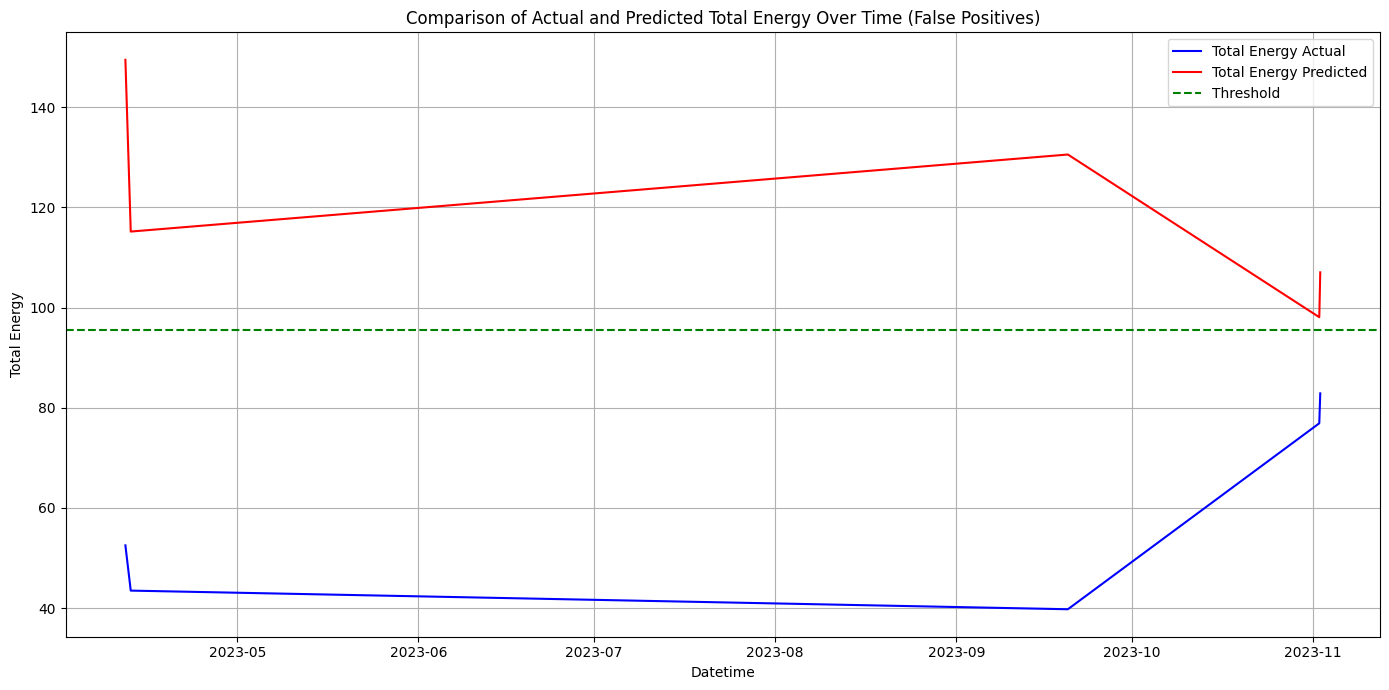

In [60]:

threshold_value = 95.48 # # average hourly energy usage in Brighton --> round((0.417/1000)*114479*2,2)
print(threshold_value)
# Plotting
plt.figure(figsize=(14, 7))  # Set the figure size as needed
plt.plot(false_positives.index, false_positives['totaEnergyActual'], label='Total Energy Actual', color='blue')
plt.plot(false_positives.index, false_positives['totaEnergyPredicted'], label='Total Energy Predicted', color='red')
# Adding a constant threshold line
plt.axhline(y=threshold_value, color='green', linestyle='--', label='Threshold')

# Adding titles and labels
plt.title('Comparison of Actual and Predicted Total Energy Over Time (False Positives)')
plt.xlabel('Datetime')
plt.ylabel('Total Energy')
plt.legend()

# Improve layout and display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig('actual_predicted_FP.png')
plt.show()

The plot shows the difference of actual and predicted total energy with the threshold value

### Analyze loss incurred on false positives

To analyze the total loss incurred for the company on false positives, the difference between threshold and actual total energy is calculated.

In [52]:
# Calculate the difference between the actual energy and the threshold
false_positives['difference'] = threshold_value - false_positives['totaEnergyActual']
false_positives

,totaEnergyActual,totaEnergyPredicted,surplusActual,surplusPredicted,difference
datetime,,,,,
2023-04-11 21:00:00,52.54,149.459106,0,1,42.94
2023-04-12 19:00:00,43.51,115.176834,0,1,51.97
2023-09-20 02:00:00,39.79,130.554016,0,1,55.69
2023-11-02 02:00:00,76.91,98.082703,0,1,18.57
2023-11-02 06:00:00,82.88,107.039116,0,1,12.60


In [53]:
cost_per_hour = false_positives['difference']*60
total_cost = round(cost_per_hour.sum(),2)
print(total_cost)

10906.2


Assuming people pay 60 pounds for 1mW.The company will lose total of 10906.20 pounds from false positives which were predicted by the models.
<br> cost per mW reference: https://www.utilitybidder.co.uk/business-electricity/price-of-1-mwh-electricity/

### Model performance over the months on test set

In [54]:
from sklearn.metrics import r2_score as r2_score_function

# calculate R2 scores for each month
monthly_r2_scores = {}

# Group by year and month
grouped = actual_pred_surplus_df.groupby([actual_pred_surplus_df.index.year, actual_pred_surplus_df.index.month])

for (year, month), group in grouped:
    r2 = r2_score_function(group['totaEnergyActual'], group['totaEnergyPredicted'])
    monthly_r2_scores[f'{year}-{month:02d}'] = r2

# Display the R2 scores for each month
for month, r2 in monthly_r2_scores.items():
    print(f"Month: {month}, R2 Score: {r2:.2f}")

Month: 2023-01, R2 Score: 0.85
Month: 2023-02, R2 Score: 0.54
Month: 2023-03, R2 Score: 0.88
Month: 2023-04, R2 Score: 0.67
Month: 2023-05, R2 Score: 0.81
Month: 2023-06, R2 Score: 0.76
Month: 2023-07, R2 Score: 0.83
Month: 2023-08, R2 Score: 0.73
Month: 2023-09, R2 Score: 0.86
Month: 2023-10, R2 Score: 0.68
Month: 2023-11, R2 Score: 0.77
Month: 2023-12, R2 Score: 0.79
Month: 2024-01, R2 Score: 0.82


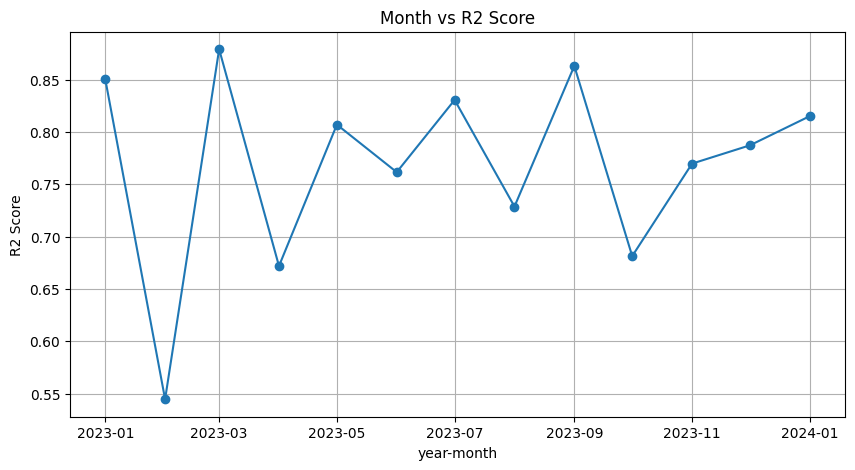

In [58]:
# plot month vs R2 score
months = [pd.to_datetime(month) for month in monthly_r2_scores.keys()] # Extract the months and R2 scores
r2_scores = list(monthly_r2_scores.values())

# Plot setup
plt.figure(figsize=(10, 5))
plt.plot(months, r2_scores, marker='o')

plt.ylabel('R2 Score')
plt.xlabel('year-month')
plt.title('Month vs R2 Score')
plt.grid(True)
plt.savefig('month_r2.png')
plt.show()

from the above graph we can say that apart from February, April and October our model performs better in forecasting energy surplus 24h in advance. In March the model shows R2 score of 0.88 which is the highes value.
<br> In May we can see there is 0.81 R2 score indicating that 81% of data fits our model which is can be considered as a good value. 
<bt>But from the graph we can see again the R2 score decreases to 0.76 in June and increases to 0.83 in July. overall most of the month have R2 scores greater than 0.75 we can say our model is ready to be diployed in May 2024 if the company can afford the cost of 10906.20

### Further analysis on actual and predicted total energy and surplus.

In [56]:
# Define a tolerance level within which considered the values nearly equal
tolerance = 0.05

# Create a new column that calculates the absolute difference between actual and predicted
actual_pred_surplus_df['actual_predicted_diff'] = abs(actual_pred_surplus_df['totaEnergyActual'] - actual_pred_surplus_df['totaEnergyPredicted'])

# Filter the DataFrame to find rows where the difference is less than or equal to the tolerance
close_values = actual_pred_surplus_df[actual_pred_surplus_df['actual_predicted_diff'] <= tolerance]

print('total rows: ', len(close_values))
print(close_values.head())

total rows:  281
                     totaEnergyActual  totaEnergyPredicted  surplusActual  \
datetime                                                                    
2023-01-07 04:00:00             30.69            30.673389              0   
2023-01-17 19:00:00              0.08             0.106353              0   
2023-01-18 05:00:00              0.20             0.225025              0   
2023-01-18 18:00:00              0.68             0.661585              0   
2023-01-19 06:00:00              0.05             0.037950              0   

                     surplusPredicted  actual_predicted_diff  
datetime                                                      
2023-01-07 04:00:00                 0               0.016611  
2023-01-17 19:00:00                 0               0.026353  
2023-01-18 05:00:00                 0               0.025025  
2023-01-18 18:00:00                 0               0.018415  
2023-01-19 06:00:00                 0               0.012050  


If we take the tolerance level as 0.05 for totalEnergyPredicted, there are 281 datetimes were predicted correctly by our model.

In [59]:
# get the hour value of each datetime
close_values['hour'] = close_values.index.hour
print(close_values['hour'].value_counts())

# get the most frequently occurring hour
most_common_hour = close_values['hour'].value_counts().idxmax()

# Print the most frequently occurring date
print("The most frequently accurately predicted hour is:", most_common_hour)

hour
4     25
2     18
20    18
22    18
19    17
5     16
6     16
23    16
16    14
0     14
3     12
21    12
7     11
8     11
1      9
18     8
10     7
17     7
9      7
11     7
13     5
14     5
12     4
15     4
Name: count, dtype: int64
The most frequently accurately predicted hour is: 4


Out of the 281 nearly correctly predicted total energy value datetimes we can see that 6pm hour occurs more. Therefore, our model mostly predicts total energy correctly at 4am. And from the results we can see mostly early mornings and night are predicted accurately